In [126]:
import altair as alt

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import math
import numpy as np
import pandas as pd

In [154]:
HOUSEHOLD_ID = 'hhid'

VEHICLE_COUNT = 'vehicle_count'
CHILDREN_COUNT = 'numchildren'
INCOME = 'hhincome_broad'
HOME_OWNERSHIP = 'home_ownership'
OFFSTREET_PARKING = 'offpark'
YEAR_RESIDENCE = 'year_residence'
WEIGHT = 'hh_wt_revised'

MEAN_AGE = 'mean_age'
PROP_WHITE = 'proportion_white'
PROP_BLACK = 'proportion_black'
PROP_ASIAN = 'proportion_asian'
PROP_HISPANIC = 'proportion_hispanic'
YEAR_EDUCATION = 'mean_education_year'
PROP_EMPLOYED = 'proportion_employed'
PROP_STUDENT = 'proportion_student'
PERSON_COUNT = 'personid_count'

MEAN_DISTANCE = 'mean_distance'
MEAN_DEPART_TIME = 'mean_depart_time'
MEAN_NUMBER_TRAVELERS = 'mean_num_travelers'
PROP_DRIVING_ALONE = 'prop_driving_alone'
PROP_DRIVING_WITH_OTHERS = 'prop_driving_with_others'
PROP_TRANSIT = 'prop_transit'
PROP_BIKING = 'prop_biking'
PROP_WALKING = 'prop_walking'
MEAN_DURATION = 'mean_duration'
PROP_WENT_HOME = 'prop_went_home'
PROP_WENT_WORK = 'prop_went_work'
PROP_ERRANDS = 'prop_errands'
PROP_SOCIAL = 'prop_social'
PROP_GAVE_RIDE = 'prop_gave_ride'

NUM_CLUSTER = 6
CLUSTER = 'cluster'

In [160]:
# load pre-processed data
result = pd.read_csv('personas_processed_psrcdat.csv', index_col=0)

# prepare for K-means clustering
res = result.dropna()
index_nomissing = res[HOUSEHOLD_ID]
res = res.set_index(HOUSEHOLD_ID)

# we're not using black/asian/hispanic indicators for K-Meanss
newres = res.drop(columns = [PROP_BLACK, PROP_ASIAN, PROP_HISPANIC])
normalized_res = (newres - newres.mean()) / newres.std()
#normalized_res = res / res.sum() * len(res)
#normalized_res[WEIGHT] = res[WEIGHT]

# K-means clustering
kmeans = KMeans(n_clusters=NUM_CLUSTER, random_state=0).fit(normalized_res)

clustered = pd.DataFrame({CLUSTER: kmeans.labels_}, index = index_nomissing)

final_dat = res.join(clustered)

final_dat.head()

final_dat.columns

Index(['numchildren', 'hh_wt_revised', 'hhincome_broad', 'hhsize',
       'vehicle_count', 'home_ownership', 'offpark', 'year_residence',
       'mean_age', 'proportion_white', 'mean_education_year',
       'proportion_black', 'proportion_asian', 'proportion_hispanic',
       'proportion_employed', 'proportion_student', 'mean_distance',
       'mean_depart_time', 'mean_num_travelers', 'prop_driving_alone',
       'prop_driving_with_others', 'prop_transit', 'prop_biking',
       'prop_walking', 'mean_duration', 'prop_went_home', 'prop_went_work',
       'prop_errands', 'prop_social', 'prop_gave_ride', 'cluster'],
      dtype='object')

In [161]:
final_dat[CLUSTER].unique()

array([4, 2, 1, 0, 3, 5])

In [162]:
for i in range(0, 6):
               print(len(final_dat[final_dat[CLUSTER] == i]))
        
print("")        
    
for i in range(0, 6):
               print(final_dat[final_dat[CLUSTER] == i][MEAN_AGE].mean())
print("")        
    
for i in range(0, 6):
               print(final_dat[final_dat[CLUSTER] == i][HOME_OWNERSHIP].mean())
        
print("")        
    
for i in range(0, 6):
               print(final_dat[final_dat[CLUSTER] == i][YEAR_EDUCATION].mean())
        
                
print("")        
    
for i in range(0, 6):
               print(final_dat[final_dat[CLUSTER] == i][YEAR_RESIDENCE].mean())

535
570
295
220
186
9

41.08045171339563
33.471564327485375
66.39915254237287
38.10852272727273
26.179038658474145
37.44444444444444

0.5644859813084112
0.14912280701754385
0.6067796610169491
0.16818181818181818
0.7741935483870968
0.5555555555555556

4.087694704049845
4.2027777777777775
4.038983050847458
3.812121212121212
4.566308243727598
4.333333333333333

7.839252336448598
3.957894736842105
13.63050847457627
5.286363636363636
9.629032258064516
6.888888888888889


In [163]:
##PCA or t-SNE

# PCA
pca = PCA(n_components=5)
#pca.fit(normalized_res) 
#print(pca.components_)
pca.fit_transform(normalized_res.values)
print(pca.explained_variance_ratio_)

pd.set_option('display.max_columns', 30)
pd.DataFrame(pca.components_, columns=normalized_res.columns, index = ['PC-1','PC-2','PC-3','PC-4','PC-5'])

[ 0.1283754   0.10673155  0.08026039  0.07209552  0.06218526]


,numchildren,hh_wt_revised,hhincome_broad,hhsize,vehicle_count,home_ownership,offpark,year_residence,mean_age,proportion_white,mean_education_year,proportion_employed,proportion_student,mean_distance,mean_depart_time,mean_num_travelers,prop_driving_alone,prop_driving_with_others,prop_transit,prop_biking,prop_walking,mean_duration,prop_went_home,prop_went_work,prop_errands,prop_social,prop_gave_ride
PC-1,0.358144,0.086911,0.296524,0.388402,0.373295,0.299780,-0.104179,0.148179,-0.068225,0.020397,0.091239,0.056203,-0.097477,0.038241,-0.105711,0.182257,0.330994,-0.036145,-0.206825,-0.001200,-0.208389,0.034056,-0.021927,0.014593,-0.064464,-0.053851,0.292373
PC-2,-0.121405,0.038675,-0.086189,-0.139245,0.063464,0.212541,-0.011282,0.344269,0.473707,0.127650,-0.046950,-0.363104,-0.149169,-0.060182,-0.041274,-0.123058,0.152516,-0.016657,-0.145624,-0.087348,-0.015253,-0.065135,-0.038445,-0.381264,0.408077,-0.002641,-0.037577
PC-3,-0.180474,0.007583,0.020134,-0.113067,0.092838,0.056679,0.001308,0.111797,0.163851,-0.056213,-0.077077,0.037465,-0.051217,0.423716,-0.282425,-0.272942,0.115782,-0.154241,0.176217,-0.012334,-0.252839,0.426207,0.193857,0.285405,-0.104871,-0.293012,-0.161890
PC-4,-0.093019,0.001823,0.033297,-0.129909,-0.029904,0.010966,-0.023235,-0.055633,-0.041518,0.111988,0.081201,0.057237,-0.015052,0.481899,0.304298,0.161015,0.081950,0.176956,-0.191263,-0.024218,0.029481,0.481724,-0.273755,-0.173504,-0.004583,0.424608,0.010749
PC-5,0.326951,0.068650,-0.211226,0.276131,-0.194868,-0.064004,0.075482,0.015617,-0.020339,-0.140052,-0.173878,-0.361586,0.185503,0.245550,-0.145147,0.248968,-0.247753,0.098150,0.238333,-0.063091,0.083052,0.243837,0.170765,-0.215514,0.128226,-0.133204,0.229791


In [164]:
final_dat.columns

Index(['numchildren', 'hh_wt_revised', 'hhincome_broad', 'hhsize',
       'vehicle_count', 'home_ownership', 'offpark', 'year_residence',
       'mean_age', 'proportion_white', 'mean_education_year',
       'proportion_black', 'proportion_asian', 'proportion_hispanic',
       'proportion_employed', 'proportion_student', 'mean_distance',
       'mean_depart_time', 'mean_num_travelers', 'prop_driving_alone',
       'prop_driving_with_others', 'prop_transit', 'prop_biking',
       'prop_walking', 'mean_duration', 'prop_went_home', 'prop_went_work',
       'prop_errands', 'prop_social', 'prop_gave_ride', 'cluster'],
      dtype='object')

0.012687605069721804
0.0549961375541696
0.028945211895668708
0.002741046831955923
0.02242426430520213
0.0


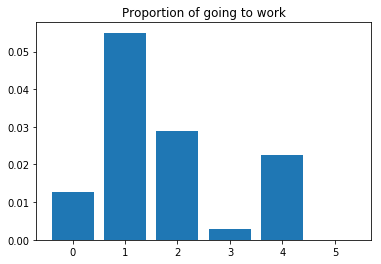

In [165]:
val = {}
for i in range(6):
    subdat = final_dat[final_dat[CLUSTER] == i]
    print(subdat[PROP_DRIVING_WITH_OTHERS].mean())
    val[i] = subdat[PROP_DRIVING_WITH_OTHERS].mean()
    
plt.bar(list(val.keys()), list(val.values()))
plt.title("Proportion of going to work")
plt.show()

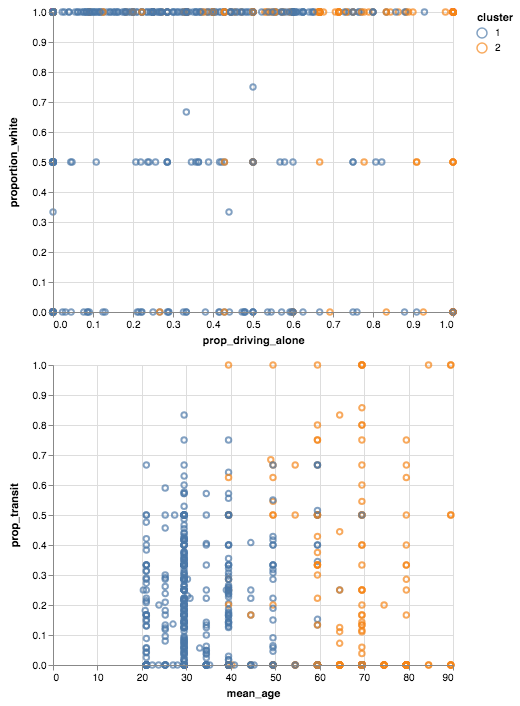

In [166]:
incbik = alt.Chart(final_dat[(final_dat[CLUSTER] == 1) | (final_dat[CLUSTER] == 2)]).mark_point().encode(
    x=PROP_DRIVING_ALONE,
    y=PROP_WHITE,
    color='cluster:N'
)

agebik = alt.Chart(final_dat[(final_dat[CLUSTER] == 1) | (final_dat[CLUSTER] == 2)]).mark_point().encode(
    x=MEAN_AGE,
    y=PROP_TRANSIT,
    color='cluster:N'
)

incbik & agebik

In [167]:
for i in [2, 3, 4, 5, 6]:
    kmeans_labels = KMeans(n_clusters=i, random_state=0).fit_predict(normalized_res)
    print(silhouette_score(normalized_res, kmeans_labels))

0.0928367292794
0.120363431034
0.111990019217
0.0925756188569
0.0958496796592


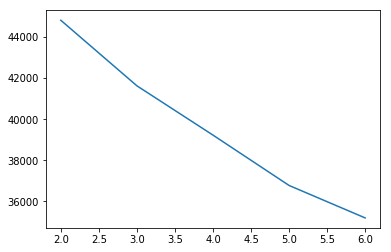

In [168]:
sse = {}
for key in [2, 3, 4, 5, 6]:
    kmeans_test = KMeans(n_clusters=key, random_state=0).fit(normalized_res)
    sse[key] = kmeans_test.inertia_ # Inertia: Sum of distances of samples to their closest cluster cente
plt.plot(list(sse.keys()), list(sse.values()))
plt.show()

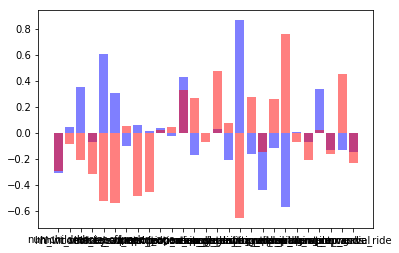

In [169]:
aa = normalized_res[(final_dat[CLUSTER] == 0)].mean()
bb = normalized_res[(final_dat[CLUSTER] == 1)].mean()
plt.bar(list(aa.keys()), list(aa), fc=(0, 0, 1, 0.5))
plt.bar(list(bb.keys()), list(bb), fc=(1, 0, 0, 0.5))
plt.show()

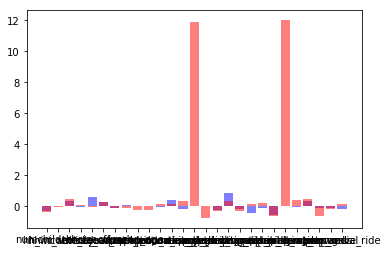

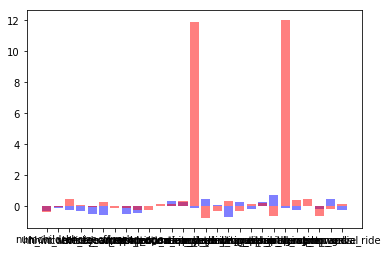

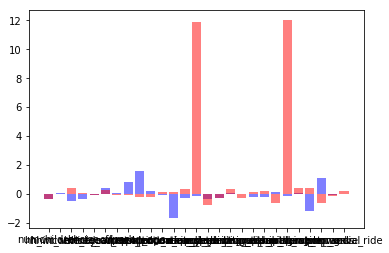

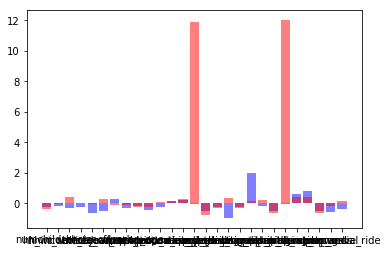

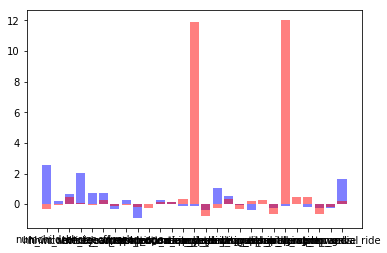

In [170]:
cluster_last = normalized_res[(final_dat[CLUSTER] == 5)].mean()
for i in [0, 1, 2, 3, 4]:
    one_cluster = normalized_res[(final_dat[CLUSTER] == i)].mean()
    plt.bar(list(one_cluster.keys()), list(one_cluster), fc=(0, 0, 1, 0.5))
    plt.bar(list(cluster_last.keys()), list(cluster_last), fc=(1, 0, 0, 0.5))
    plt.show()

So as we can see above, there are two egregiously large values for cluster=4. As you can see below, this is mean_distance and mean_duration. So these five households take very long trips on average.. all the other values are comparable. I would suggest we don't include this cluster. The best way may be starting with K=6 and exclude this one from Personas. 

In [171]:
cluster_last

numchildren                 -0.331463
hh_wt_revised               -0.024099
hhincome_broad               0.444887
hhsize                       0.056573
vehicle_count               -0.061468
home_ownership               0.286622
offpark                     -0.085074
year_residence              -0.075625
mean_age                    -0.211568
proportion_white            -0.221403
mean_education_year          0.125208
proportion_employed          0.173511
proportion_student           0.318708
mean_distance               11.872565
mean_depart_time            -0.750590
mean_num_travelers          -0.270031
prop_driving_alone           0.363881
prop_driving_with_others    -0.292265
prop_transit                 0.177763
prop_biking                  0.241791
prop_walking                -0.620353
mean_duration               12.000950
prop_went_home               0.443114
prop_went_work               0.445047
prop_errands                -0.642429
prop_social                 -0.151716
prop_gave_ri

In [172]:
original_cluster_last = res[final_dat[CLUSTER] == 5]
original_cluster_last

,numchildren,hh_wt_revised,hhincome_broad,hhsize,vehicle_count,home_ownership,offpark,year_residence,mean_age,proportion_white,mean_education_year,proportion_black,proportion_asian,proportion_hispanic,proportion_employed,proportion_student,mean_distance,mean_depart_time,mean_num_travelers,prop_driving_alone,prop_driving_with_others,prop_transit,prop_biking,prop_walking,mean_duration,prop_went_home,prop_went_work,prop_errands,prop_social,prop_gave_ride
hhid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17106390,0,25.605444,5.0,2,0,1.0,10,20,39.5,1.0,4.0,0.0,0.0,0.0,1.000000,0.500000,388.158658,790.625000,1.625000,0.000000,0.0,0.285714,0.285714,0.428571,345.125000,0.333333,0.500000,0.166667,0.0,0.000000
17108315,0,25.294495,1.0,2,1,0.0,0,2,21.0,0.5,5.0,0.0,0.0,0.5,1.000000,0.000000,778.002888,676.666667,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,691.333333,0.000000,0.000000,0.000000,1.0,0.000000
17111142,0,13.854597,5.0,1,1,1.0,1,10,39.5,0.0,6.0,0.0,1.0,0.0,1.000000,0.000000,839.797279,715.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,732.333333,1.000000,0.000000,0.000000,0.0,0.000000
17120172,0,18.712791,3.0,3,1,0.0,1,3,29.5,1.0,6.0,0.0,0.0,0.0,0.666667,0.666667,392.092635,538.125000,1.000000,0.285714,0.0,0.428571,0.285714,0.000000,347.750000,0.375000,0.375000,0.250000,0.0,0.000000
17133382,0,22.183373,5.0,2,2,0.0,1,3,29.5,0.0,5.0,0.0,0.0,0.0,1.000000,0.000000,407.379837,339.166667,1.333333,1.000000,0.0,0.000000,0.000000,0.000000,367.500000,0.400000,0.400000,0.000000,0.0,0.200000
17134916,0,1043.118564,5.0,2,0,0.0,1,1,29.5,0.5,4.0,0.0,0.5,0.0,1.000000,0.000000,613.503697,603.000000,1.000000,0.000000,0.0,0.500000,0.000000,0.500000,545.000000,0.333333,0.333333,0.333333,0.0,0.000000
17137245,0,11.446515,3.0,1,1,1.0,2,20,59.5,1.0,2.0,0.0,0.0,0.0,1.000000,0.000000,1533.231079,182.500000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,1357.500000,0.000000,1.000000,0.000000,0.0,0.000000
17139445,0,8.835976,5.0,1,1,1.0,1,1,59.5,1.0,4.0,0.0,0.0,0.0,0.000000,0.000000,1055.840000,652.500000,2.000000,0.000000,0.0,1.000000,0.000000,0.000000,1001.500000,1.000000,0.000000,0.000000,0.0,0.000000
17142915,0,186.300000,5.0,2,2,1.0,4,2,29.5,1.0,3.0,0.0,0.0,0.0,1.000000,0.500000,368.098161,865.625000,1.250000,1.000000,0.0,0.000000,0.000000,0.000000,331.000000,0.333333,0.333333,0.166667,0.0,0.166667


In [3]:
"""
plt.hist(hh[INCOME].dropna(), label = 'income')
plt.legend(loc='upper right')
plt.show()
plt.hist(hh.hhsize, label = 'household size')
plt.legend(loc='upper right')
plt.show()
plt.hist(hh.vehicle_count, label = 'number of vehicles')
plt.legend(loc='upper right')
plt.show()
plt.hist(hh[CHILDREN_COUHT], label = 'number of children')
plt.legend(loc='upper right')
plt.show()
plt.hist(hh[HOME_OWNERSHIP].dropna(), label = 'home ownership')
plt.legend(loc='upper right')
plt.show()
plt.hist(hh[OFFSTREET_PARKING].dropna(), label = 'off-street parking')
plt.legend(loc='upper right')
plt.show()
plt.hist(hh[YEAR_RESIDENCE].dropna(), label = 'year of residence')
plt.legend(loc='upper right')
plt.show()
"""

"\nplt.hist(hh[INCOME].dropna(), label = 'income')\nplt.legend(loc='upper right')\nplt.show()\nplt.hist(hh.hhsize, label = 'household size')\nplt.legend(loc='upper right')\nplt.show()\nplt.hist(hh.vehicle_count, label = 'number of vehicles')\nplt.legend(loc='upper right')\nplt.show()\nplt.hist(hh[CHILDREN_COUHT], label = 'number of children')\nplt.legend(loc='upper right')\nplt.show()\nplt.hist(hh[HOME_OWNERSHIP].dropna(), label = 'home ownership')\nplt.legend(loc='upper right')\nplt.show()\nplt.hist(hh[OFFSTREET_PARKING].dropna(), label = 'off-street parking')\nplt.legend(loc='upper right')\nplt.show()\nplt.hist(hh[YEAR_RESIDENCE].dropna(), label = 'year of residence')\nplt.legend(loc='upper right')\nplt.show()\n"

In [174]:
final_dat.to_csv('personas_clustered.csv')